In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
import pydotplus
import graphviz

In [2]:
wine = pd.read_csv("./DATA/winequality-white.csv", sep=";", encoding='utf-8')

In [3]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
wine.shape

(4898, 12)

# 레이블의 형태를 확인해보자

Text(0, 0.5, 'frequency')

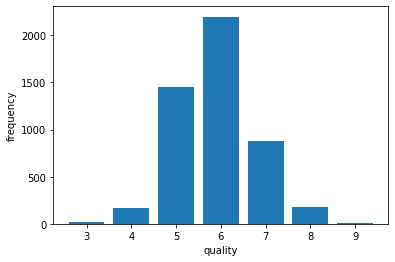

In [5]:
quality_dist = wine['quality'].value_counts()
plt.bar(quality_dist.index, quality_dist)
plt.xlabel('quality')
plt.ylabel('frequency')

In [6]:
wine['quality'].describe()

count    4898.000000
mean        5.877909
std         0.885639
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: quality, dtype: float64

In [7]:
values, base = np.histogram(wine['quality'], bins=20)

In [8]:
kumulativ = np.cumsum(values/wine.shape[0])

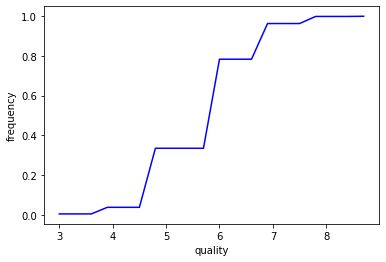

In [9]:
values, base = np.histogram(wine['quality'], bins=20)
kumulativ = np.cumsum(values/wine.shape[0])
plt.plot(base[:-1], kumulativ, c='blue')
plt.xlabel('quality')
plt.ylabel('frequency')
plt.show()

In [10]:
indeksDaarlig = wine.loc[wine['quality'] <= 6].index
indeksGod = wine.loc[wine['quality'] > 6].index
wine.iloc[indeksDaarlig, wine.columns.get_loc('quality')] = 0
wine.iloc[indeksGod, wine.columns.get_loc('quality')] = 1

In [11]:
wine['quality'].value_counts()

0    3838
1    1060
Name: quality, dtype: int64

In [12]:
x = wine.drop('quality',axis=1)
y = wine['quality']

In [13]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2019)

In [30]:
DTC = DecisionTreeClassifier(max_depth=2,criterion = "entropy")
DTC.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [96]:
import graphviz
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image

In [98]:
dt_dot_data = export_graphviz(DTC, out_file = None,
                                  feature_names = wine.columns.values[:-1],
                                  class_names = list(wine['quality'].values),
                                  filled = True, rounded = True,
                                  special_characters = True)

In [99]:
dt_graph = pydotplus.graph_from_dot_data(dt_dot_data)

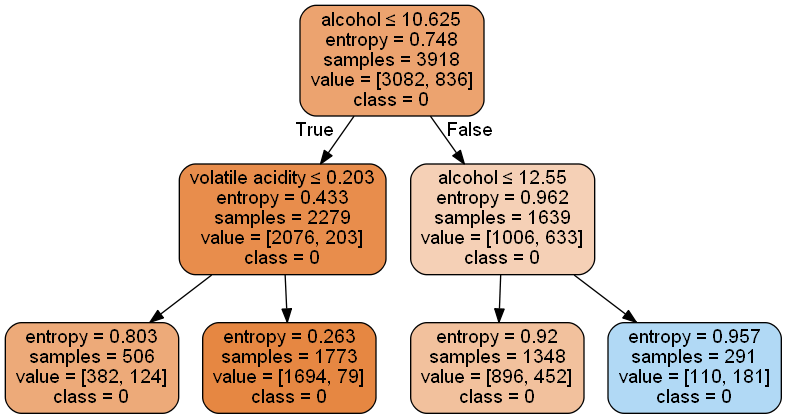

In [100]:
Image(dt_graph.create_png())

# 그리드 서치를 이용해서 하이퍼 파라미터를 찾아보자

## 에이다 부스트에 디시즌트리를 사용

In [101]:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=KFold(n_splits=5), scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 5 folds for each of 112 candidates, totalling 560 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 116 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 560 out of 560 | elapsed:    4.8s finished


In [102]:
prediction = gsadaDTC.predict(X_test)
print('Accuracy =', accuracy_score(y_test, prediction))

Accuracy = 0.8428571428571429


# 랜덤포레스트

In [105]:
# RFC Parameters tunning 
RFC = RandomForestClassifier(random_state=2019)

## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=KFold(n_splits=5), scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   13.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:  3.3min finished


In [106]:
print("테스트 세트 정확도: {:.3f}".format(gsRFC.score(X_test, y_test)))

테스트 세트 정확도: 0.878


# 익스트림 랜덤트리

In [107]:
# 랜덤포레스트보다 더 무작위하게 특성을 나눔
ExtC = ExtraTreesClassifier()

ex_param_grid = {"max_depth": [None],
                "max_features": [1, 3, 10],
                "min_samples_split": [2, 3, 10],
                "min_samples_leaf": [1, 3, 10],
                "bootstrap": [False],
                "n_estimators" : [100,300],
                "criterion": ["gini"]}

gsExtC = GridSearchCV(ExtC, param_grid = ex_param_grid, cv=KFold(n_splits=5), scoring="accuracy", n_jobs = 4, verbose = 1)

gsExtC.fit(X_train, y_train)

ExtC_best = gsExtC.best_estimator_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    7.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   36.0s
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:  1.1min finished


In [109]:
print("테스트 세트 정확도: {:.3f}".format(gsExtC.score(X_test, y_test)))

테스트 세트 정확도: 0.872


# XG 부스트

In [110]:
from sklearn.model_selection import RandomizedSearchCV

from xgboost import XGBClassifier
xg = XGBClassifier(random_state=2019)

In [115]:
xg_param_grid = {"learning_rate": [0.02,0.1],
              "n_estimators": [100, 300],
              "max_depth": [2,3,4],
              "min_child_weight": [1, 2],
              "gamma":[0,1],
              "subsample": [0,1],
              "colsample_bytree" :[0, 1],
              "criterion": ["gini", "entropy"]}

random_search = RandomizedSearchCV(xg, param_distributions=xg_param_grid,
                                   n_iter=200, cv=KFold(n_splits=5), iid=False, verbose = 1)

# start = time()
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  5.5min finished


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           object...
                                           verbosity=1),
                   iid=False, n_iter=200, n_jobs=None,
                   param_distributions={'colsample_bytree': [0, 1],
                                        'criterion': ['gini', 'ent

In [118]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, criterion='entropy',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=2, missing=None, n_estimators=300, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=2019,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [119]:
print("테스트 세트 정확도: {:.3f}".format(random_search.score(X_test, y_test)))

테스트 세트 정확도: 0.863
